# Import e funzioni 

In [1]:
!pip install geopandas
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from tqdm import tqdm
import geopandas as gpd
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import transform
import pyproj
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import os

# Convertire miglia nautiche in gradi (approssimazione)
def miles_to_degrees(miles):
    return miles / 60.0

radius_degrees = miles_to_degrees(10)  # raggio di 10 miglia nautiche

# Funzione per creare un cerchio attorno a un punto
def create_circle_around_point(point, radius):
    return point.buffer(radius)

# read dati

In [2]:
ais=pd.read_csv('/kaggle/input/ais-tesi/2022_5386954_emissions_hourly.csv',low_memory=False).reset_index(drop=False) 
ports = pd.read_csv('/kaggle/input/centroidi-tesi/best_centroids (2).csv', sep=';')
ports.columns=['Unnamed: 0', 'PORT_CODE', 'LONGITUDE', 'LATITUDE','PORT_NAME']

# da ogni ais accoppia porti, e definisce i viaggi


In [3]:
# Leggi il dataframe dei porti e trasformalo in geopandas e crea cerchio
ports=ports[['PORT_CODE','LONGITUDE','LATITUDE']].copy()
ports['geometry'] = ports.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
ports_gdf = gpd.GeoDataFrame(ports, geometry='geometry')
ports_gdf['geometry'] = ports_gdf['geometry'].apply(lambda point: create_circle_around_point(point, radius_degrees))
ports_gdf.crs = "EPSG:4326"
ports_gdf['PORT_CODE'] = ports_gdf['PORT_CODE'].astype(str)


directory = '/kaggle/input/ais-tesi'
data = []

for file_name in tqdm(os.listdir(directory)):
    if file_name.endswith('.csv'):
        # Leggi il dataframe dei AIS e trasformalo in geopandas,
        file_path = os.path.join(directory, file_name)
        ais = pd.read_csv(file_path, low_memory=False).reset_index(drop=False)
        imo = file_name.split('_')[1]
        ais=ais[['index', 'LONGITUDE','LATITUDE','SOG']].copy()
        ais['geometry'] = ais.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
        ais_gdf = gpd.GeoDataFrame(ais, geometry='geometry')
        ais_gdf.crs = "EPSG:4326" 
        # Ora che sono tutti geopandas possiamo fare il join per vedere ogni segnale rispetto a ogni porto
        intersections = gpd.sjoin(ais_gdf, ports_gdf, how='left', predicate='intersects')
        intersections_cleaned = intersections.drop_duplicates(subset=['index'])
        intersections_cleaned.loc[intersections_cleaned['SOG'] > 3, 'PORT_CODE'] = 'move'
        intersections_cleaned['PORT_CODE'] = intersections_cleaned['PORT_CODE'].fillna('unknown')
        result = []
        for code in intersections_cleaned['PORT_CODE']:
            if code != 'move':
                # Aggiungi il codice se non è già l'ultimo aggiunto
                if not result or result[-1] != code:
                    result.append(code)
        arcs = [(result[i], result[i + 1]) for i in range(len(result) - 1)]
        filtered_arcs = [(source, destination) for source, destination in arcs if source != 'unknown' and destination != 'unknown']
        for source, destination in filtered_arcs:
            data.append({'IMO': imo, 'Source': source, 'Destination': destination})
archi = pd.DataFrame(data)
archi=archi.groupby(['Source','Destination']).count().reset_index()
archi.columns=['Source', 'Target', 'Weight']
archi['Source'] = archi['Source'].astype(str)
archi.to_csv('archi.csv', index=False)
ports.to_csv('ports.csv', index=False)

/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:131: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
  0%|          | 0/126 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:131: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
  1%|        

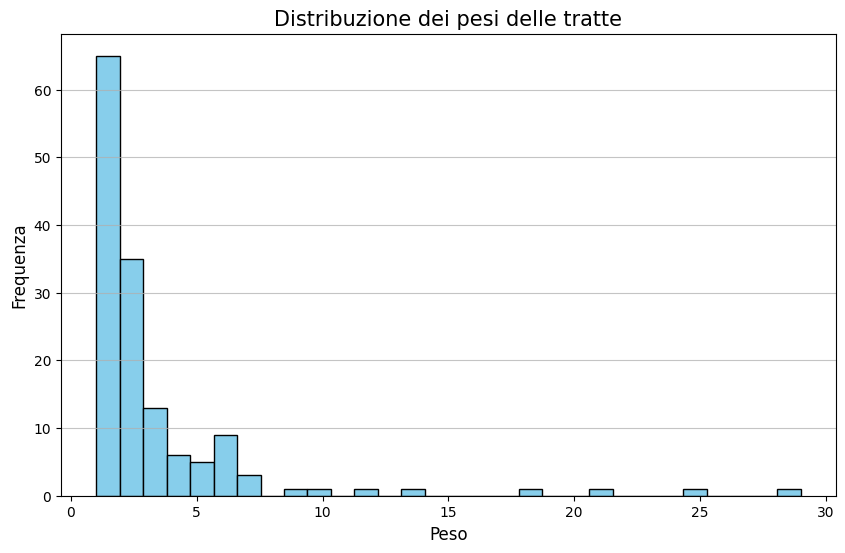

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il dataframe archi
archi = pd.read_csv('archi.csv')  # Assicurati che il file CSV sia nella stessa directory o fornisci il percorso corretto

# Crea un istogramma dei pesi
plt.figure(figsize=(10, 6))
plt.hist(archi['Weight'], bins=30, color='skyblue', edgecolor='black')

# Aggiungi titoli e etichette
plt.title('Distribuzione dei pesi delle tratte', fontsize=15)
plt.xlabel('Peso', fontsize=12)
plt.ylabel('Frequenza', fontsize=12)

# Mostra la griglia per facilitare la lettura
plt.grid(axis='y', alpha=0.75)

# Mostra il grafico
plt.show()


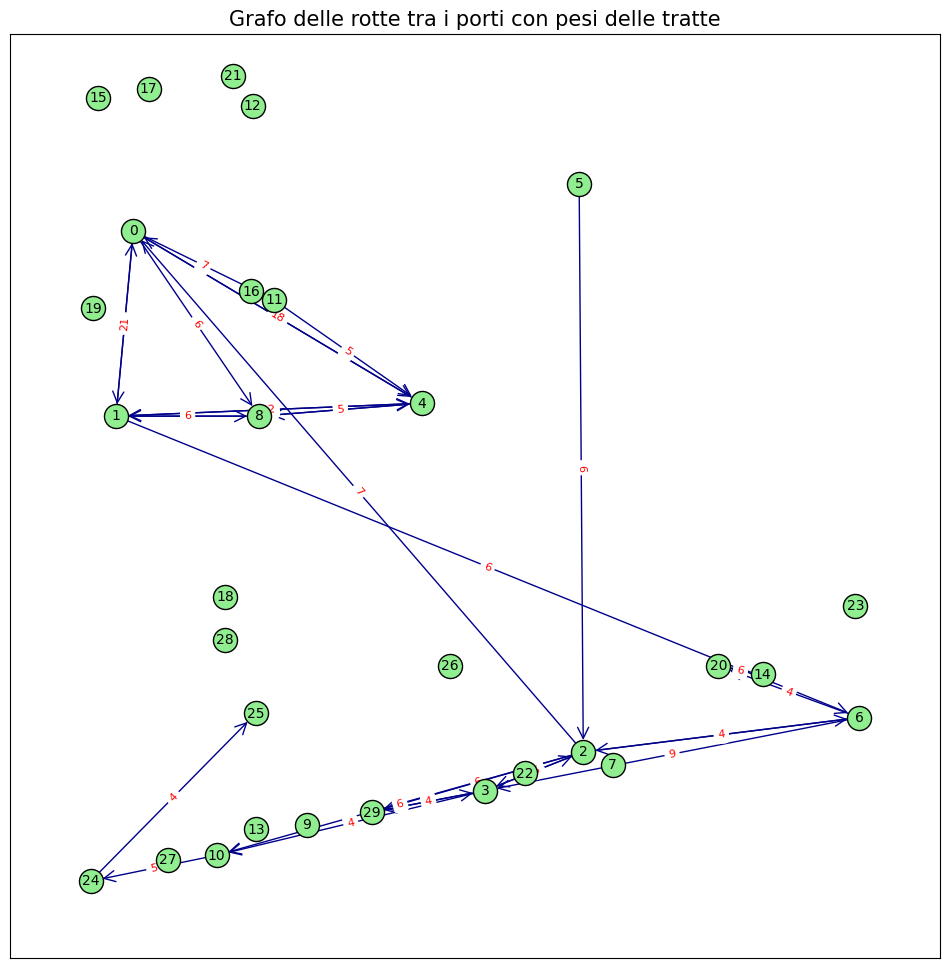

In [5]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

# Leggi i dati dai file CSV
ports = pd.read_csv('/kaggle/input/centroidi-tesi/best_centroids (2).csv', sep=';')
ports.columns=['Unnamed: 0', 'PORT_CODE', 'LONGITUDE', 'LATITUDE','PORT_NAME']
archi = pd.read_csv('archi.csv')  # Archi con pesi
archi=archi[archi['Weight']>3]

# Crea il grafo
G = nx.DiGraph()

# Aggiungi i nodi al grafo con attributi
for index, row in ports.iterrows():
    G.add_node(row['PORT_CODE'], pos=(row['LONGITUDE'], row['LATITUDE']))

# Aggiungi gli archi al grafo con pesi
for index, row in archi.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

# Disegna il grafo
plt.figure(figsize=(12, 12))

# Ottieni le posizioni dei nodi dal grafo
pos = nx.get_node_attributes(G, 'pos')

# Modifica il colore dei nodi e degli archi per migliorare la leggibilità
# Disegna i nodi con un colore chiaro
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightgreen', edgecolors='black')

# Disegna gli archi con un colore più scuro e frecce grandi
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='darkblue')

# Aggiungi etichette ai nodi (PORT_CODE) con un font scuro
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

# Estrai i pesi degli archi
edge_labels = {(row['Source'], row['Target']): row['Weight'] for index, row in archi.iterrows()}

# Disegna le etichette dei pesi sugli archi con un colore rosso per evidenziare
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

# Imposta il titolo
plt.title("Grafo delle rotte tra i porti con pesi delle tratte", fontsize=15)
plt.show()


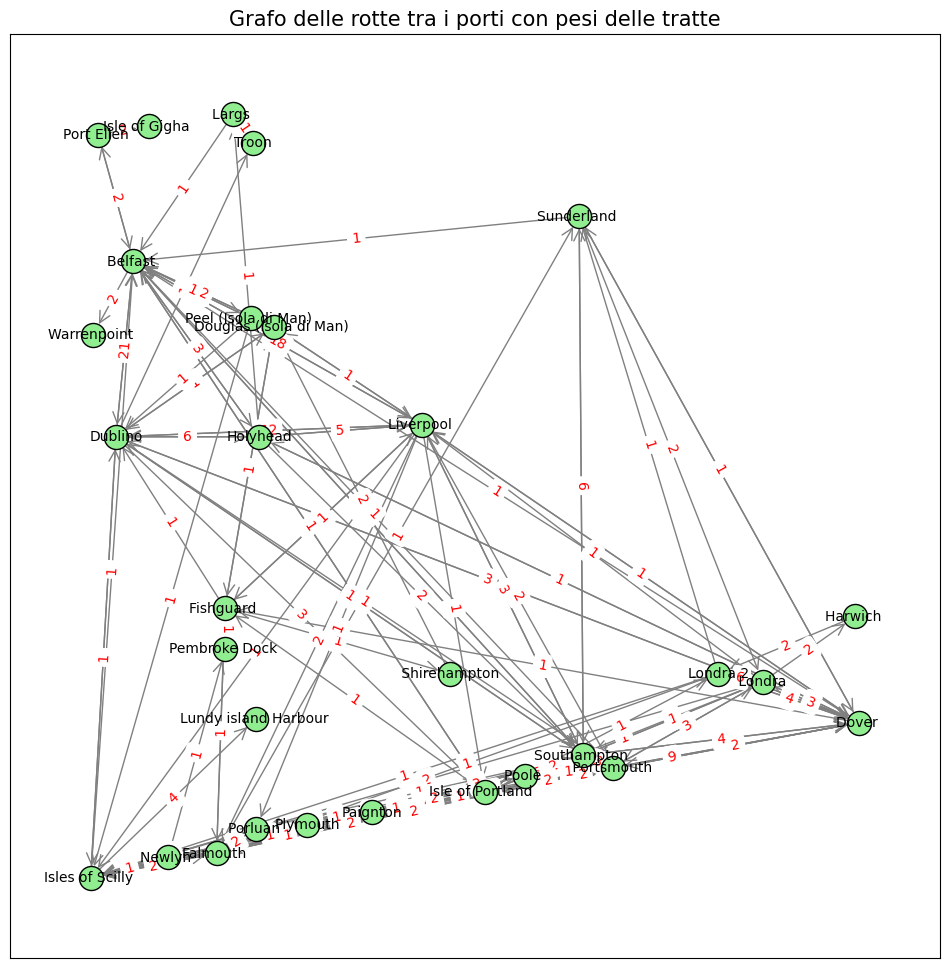

In [6]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

# Leggi i dati dai file CSV
ports = pd.read_csv('/kaggle/input/centroidi-tesi/best_centroids (2).csv', sep=';')
ports.columns = ['Unnamed: 0', 'PORT_CODE', 'LONGITUDE', 'LATITUDE', 'PORT_NAME']
archi = pd.read_csv('archi.csv')  # Archi con pesi

# Crea il grafo
G = nx.DiGraph()

# Aggiungi i nodi al grafo con attributi
for index, row in ports.iterrows():
    G.add_node(row['PORT_CODE'], pos=(row['LONGITUDE'], row['LATITUDE']), port_name=row['PORT_NAME'])

# Aggiungi gli archi al grafo con pesi
for index, row in archi.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

# Disegna il grafo
plt.figure(figsize=(12, 12))

# Ottieni le posizioni dei nodi dal grafo
pos = nx.get_node_attributes(G, 'pos')

# Modifica il colore dei nodi e degli archi per migliorare la leggibilità
# Disegna i nodi con un colore chiaro
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightgreen', edgecolors='black')

# Disegna gli archi con un colore più scuro e frecce grandi
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='grey')

# Crea un dizionario che mappa i PORT_CODE ai PORT_NAME
node_labels = {row['PORT_CODE']: row['PORT_NAME'] for index, row in ports.iterrows()}

# Aggiungi le etichette dei PORT_NAME sui nodi
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')

# Estrai i pesi degli archi
edge_labels = {(row['Source'], row['Target']): row['Weight'] for index, row in archi.iterrows()}

# Disegna le etichette dei pesi sugli archi con un colore rosso per evidenziare
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)

# Imposta il titolo
plt.title("Grafo delle rotte tra i porti con pesi delle tratte", fontsize=15)
plt.show()


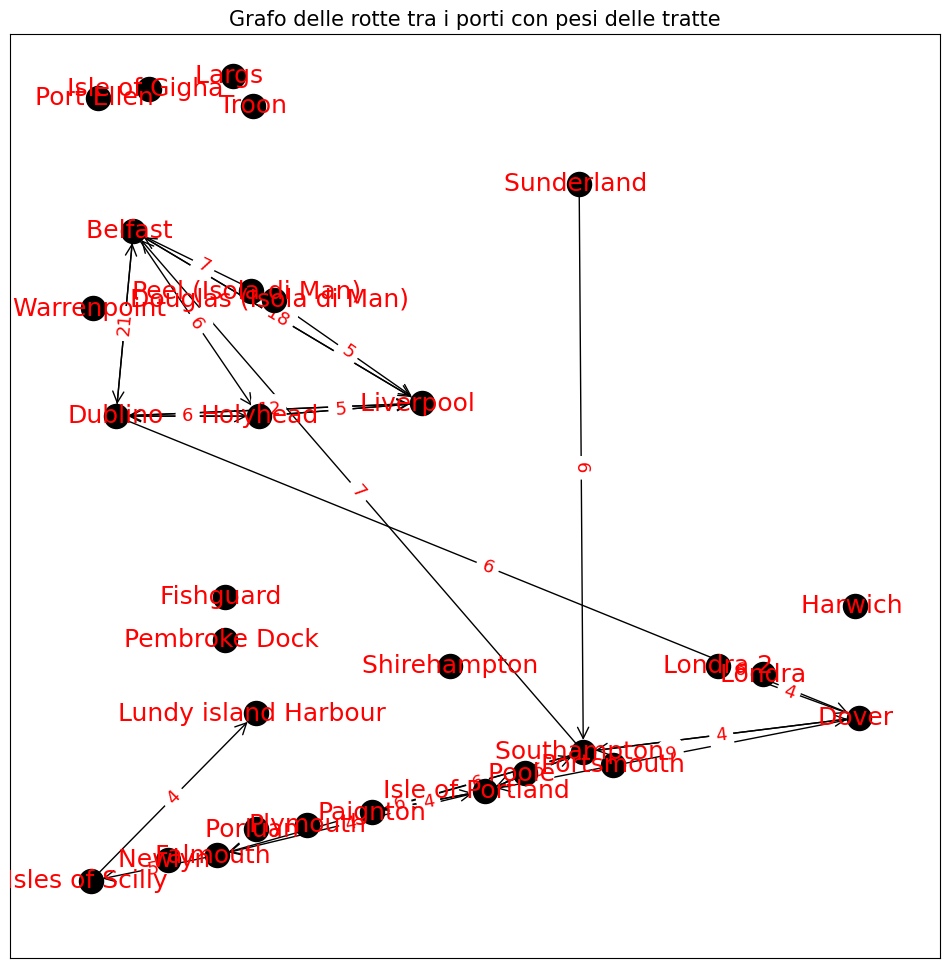

In [7]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

# Leggi i dati dai file CSV
ports = pd.read_csv('/kaggle/input/centroidi-tesi/best_centroids (2).csv', sep=';')
ports.columns = ['Unnamed: 0', 'PORT_CODE', 'LONGITUDE', 'LATITUDE', 'PORT_NAME']
archi = pd.read_csv('archi.csv')  # Archi con pesi
archi = archi[archi['Weight'] > 3]

# Crea il grafo
G = nx.DiGraph()

# Aggiungi i nodi al grafo con attributi
for index, row in ports.iterrows():
    G.add_node(row['PORT_CODE'], pos=(row['LONGITUDE'], row['LATITUDE']), port_name=row['PORT_NAME'])

# Aggiungi gli archi al grafo con pesi
for index, row in archi.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

# Disegna il grafo
plt.figure(figsize=(12, 12))

# Ottieni le posizioni dei nodi dal grafo
pos = nx.get_node_attributes(G, 'pos')

# Modifica il colore dei nodi e degli archi per migliorare la leggibilità
# Disegna i nodi con un colore chiaro
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='black', edgecolors='black')

# Disegna gli archi con un colore più scuro e frecce grandi
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='black')

# Crea un dizionario che mappa i PORT_CODE ai PORT_NAME
node_labels = {row['PORT_CODE']: row['PORT_NAME'] for index, row in ports.iterrows()}

# Aggiungi le etichette dei PORT_NAME sui nodi con colore sgargiante e testo più grande
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=18, font_color='red')  # Colore arancione e font più grande

# Estrai i pesi degli archi
edge_labels = {(row['Source'], row['Target']): row['Weight'] for index, row in archi.iterrows()}

# Disegna le etichette dei pesi sugli archi con un colore rosso per evidenziare
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=13)

# Imposta il titolo
plt.title("Grafo delle rotte tra i porti con pesi delle tratte", fontsize=15)
plt.show()


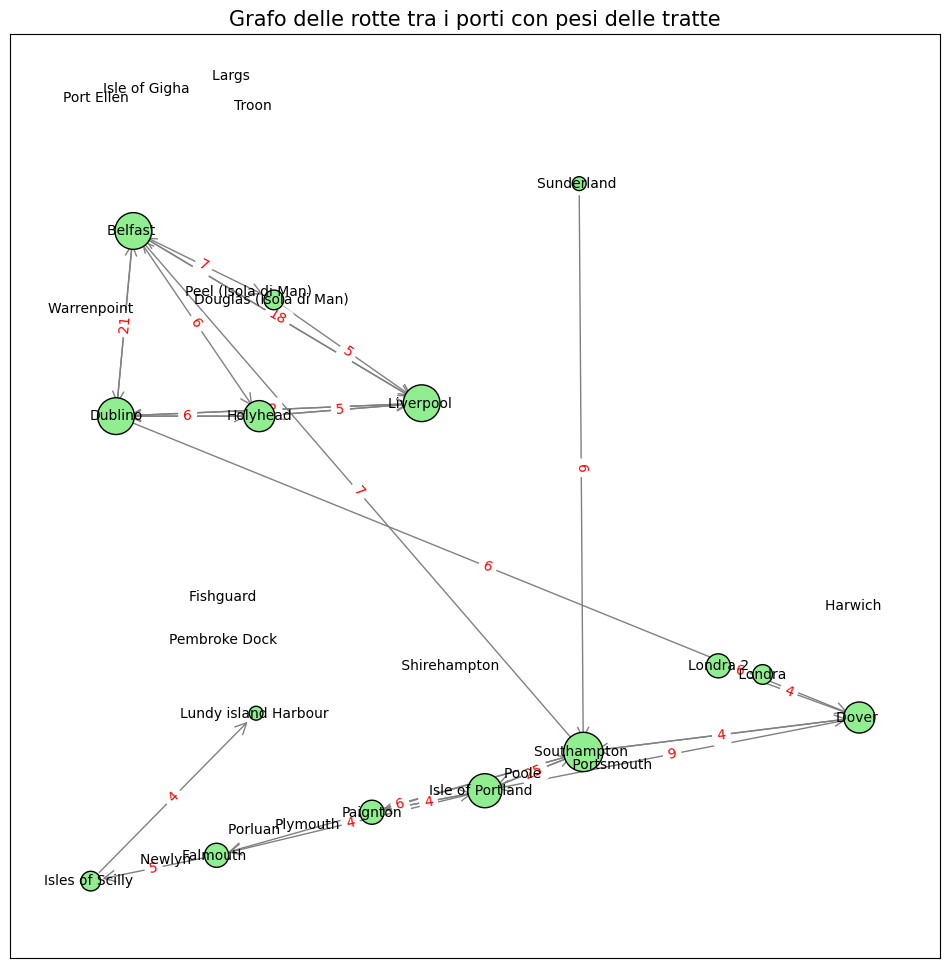

In [8]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

# Leggi i dati dai file CSV
ports = pd.read_csv('/kaggle/input/centroidi-tesi/best_centroids (2).csv', sep=';')
ports.columns = ['Unnamed: 0', 'PORT_CODE', 'LONGITUDE', 'LATITUDE', 'PORT_NAME']
archi = pd.read_csv('archi.csv')  # Archi con pesi
archi=archi[archi['Weight']>3]
# Crea il grafo
G = nx.DiGraph()

# Aggiungi i nodi al grafo con attributi
for index, row in ports.iterrows():
    G.add_node(row['PORT_CODE'], pos=(row['LONGITUDE'], row['LATITUDE']), port_name=row['PORT_NAME'])

# Aggiungi gli archi al grafo con pesi
for index, row in archi.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

# Calcola il grado (degree) per ogni nodo
node_degree = dict(G.degree())

# Ottieni la dimensione del nodo basata sul grado (puoi moltiplicare per scalare)
node_size = [node_degree[node] * 100 for node in G.nodes()]  # Moltiplicato per 100 per avere una buona scala

# Disegna il grafo
plt.figure(figsize=(12, 12))

# Ottieni le posizioni dei nodi dal grafo
pos = nx.get_node_attributes(G, 'pos')

# Modifica il colore dei nodi e degli archi per migliorare la leggibilità
# Disegna i nodi con un colore chiaro, dimensionati in base al loro grado
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='lightgreen', edgecolors='black')

# Disegna gli archi con un colore più scuro e frecce grandi
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='grey')

# Crea un dizionario che mappa i PORT_CODE ai PORT_NAME
node_labels = {row['PORT_CODE']: row['PORT_NAME'] for index, row in ports.iterrows()}

# Aggiungi le etichette dei PORT_NAME sui nodi
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')

# Estrai i pesi degli archi
edge_labels = {(row['Source'], row['Target']): row['Weight'] for index, row in archi.iterrows()}

# Disegna le etichette dei pesi sugli archi con un colore rosso per evidenziare
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)

# Imposta il titolo
plt.title("Grafo delle rotte tra i porti con pesi delle tratte", fontsize=15)
plt.show()


# ogni colore rapprrsenta una comunità 
ogni nodo appartiene a una comunità

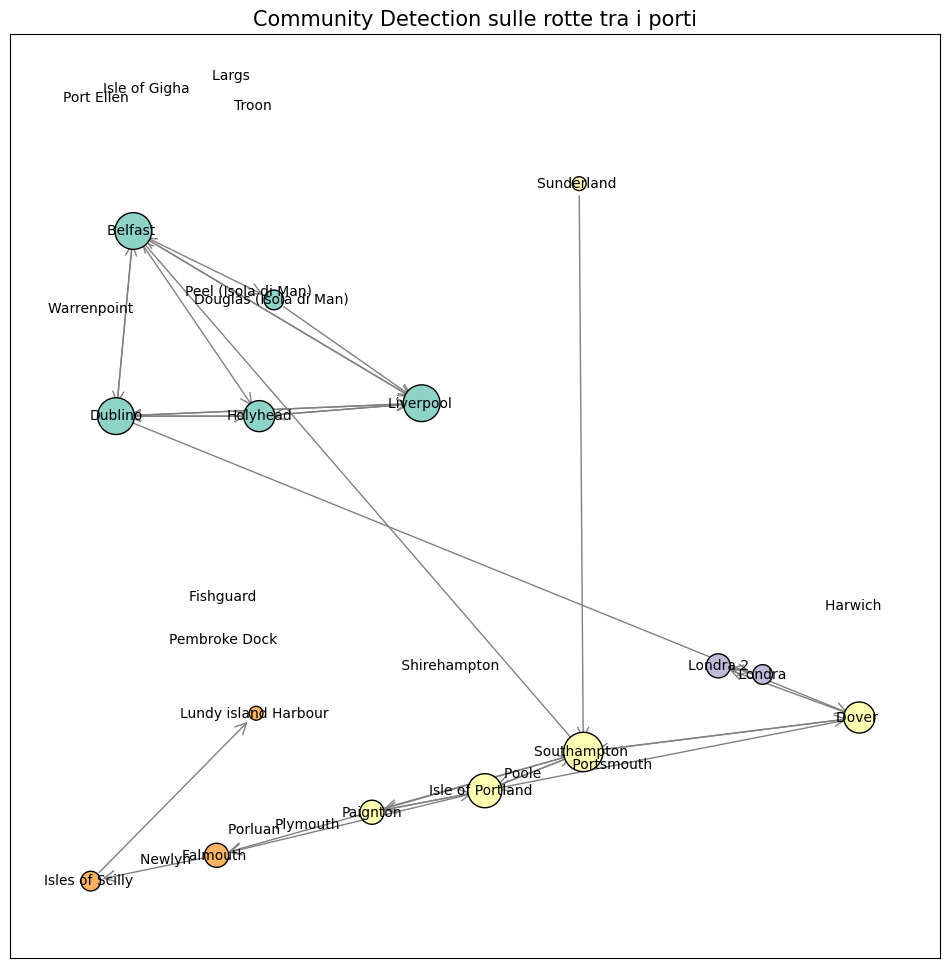

In [9]:
import community as community_louvain

# Calcola le comunità usando l'algoritmo di Louvain
partition = community_louvain.best_partition(G.to_undirected())  # Lavora su un grafo non orientato

# Aggiungi la community come attributo dei nodi
nx.set_node_attributes(G, partition, 'community')

# Colora i nodi in base alla comunità
community_colors = [partition[node] for node in G.nodes()]

plt.figure(figsize=(12, 12))

# Ridisegna il grafo con i nodi colorati per comunità
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=community_colors, cmap=plt.cm.Set3, edgecolors='black')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='grey')
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')

# Imposta il titolo
plt.title("Community Detection sulle rotte tra i porti", fontsize=15)
plt.show()


# distribuzione del grado dei nodi

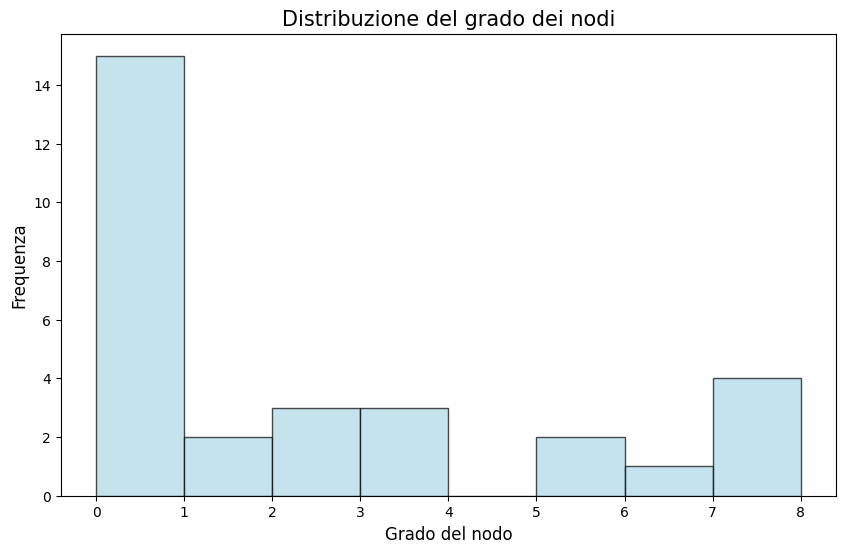

In [10]:
# Estrai i gradi dei nodi (somma di in-degree e out-degree per ogni nodo)
degree_sequence = [G.degree(node) for node in G.nodes()]

# Visualizza l'istogramma della distribuzione dei gradi
plt.figure(figsize=(10, 6))

plt.hist(degree_sequence, bins=range(min(degree_sequence), max(degree_sequence) + 1), color='lightblue', edgecolor='black', alpha=0.7)

# Imposta i titoli e le etichette degli assi
plt.title("Distribuzione del grado dei nodi", fontsize=15)
plt.xlabel("Grado del nodo", fontsize=12)
plt.ylabel("Frequenza", fontsize=12)

# Mostra il grafico
plt.show()

# Lista del grado dei nodi

In [11]:
import pandas as pd
import networkx as nx

# Supponiamo che 'df_viaggi' e 'G' siano già definiti

# Calcola il grado di ogni nodo
degree_sequence = G.degree()  # Restituisce una lista di tuple (nodo, grado)

# Ordina i nodi in base al grado in modo decrescente
sorted_nodes = sorted(degree_sequence, key=lambda x: x[1], reverse=True)

# Se vuoi i primi N nodi con grado maggiore (per esempio, i primi 10)
N = 30
top_nodes = sorted_nodes[:N]

# Crea un DataFrame per visualizzare i nodi (PORT_CODE) e i loro gradi
top_nodes_df = pd.DataFrame(top_nodes, columns=['PORT_CODE', 'Grado'])

# Unisci il DataFrame dei nodi con il DataFrame 'ports' per ottenere i nomi dei porti
top_nodes_df = pd.merge(top_nodes_df, ports[['PORT_CODE', 'PORT_NAME']], on='PORT_CODE', how='left')

# Visualizza il DataFrame con PORT_CODE, PORT_NAME e Grado
print(top_nodes_df[['PORT_CODE', 'PORT_NAME', 'Grado']])


    PORT_CODE                PORT_NAME  Grado
0           2             Southampton       8
1           0                 Belfast       7
2           1                  Dublino      7
3           4               Liverpool       7
4           3       Isle of Portland        6
5           6                   Dover       5
6           8                 Holyhead      5
7          10                Falmouth       3
8          20                 Londra 2      3
9          29                 Paignton      3
10         11  Douglas (Isola di Man)       2
11         14                  Londra       2
12         24         Isles of Scilly       2
13          5              Sunderland       1
14         25    Lundy island Harbour       1
15          7              Portsmouth       0
16          9                 Plymouth      0
17         12                    Troon      0
18         13                 Porluan       0
19         15              Port Ellen       0
20         16     Peel (Isola di M

# Esporto in formato SHAPE

In [12]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Convertire il DataFrame in geometrie di punti
geometry = [Point(xy) for xy in zip(ports['LONGITUDE'], ports['LATITUDE'])]

# Creare un GeoDataFrame
gdf = gpd.GeoDataFrame(ports, geometry=geometry)

# Impostare un sistema di riferimento spaziale (SRID), ad esempio WGS84
gdf.crs = "EPSG:4326"

# Esportare come shapefile
gdf.to_file('output_shapefile.shp')


# Degree centrality grado(v)/N-1

In [13]:
# Calcola la degree centrality
degree_centrality = nx.degree_centrality(G)

# Crea una mappatura tra PORT_CODE e PORT_NAME dal DataFrame ports
port_code_to_name = dict(zip(ports['PORT_CODE'], ports['PORT_NAME']))

# Stampa la degree centrality usando i PORT_NAME invece dei PORT_CODE
print("Grado dei nodi (Degree Centrality) con PORT_NAME:")
for port_code, centrality in degree_centrality.items():
    port_name = port_code_to_name.get(port_code, 'Unknown')  # Ottieni il nome del porto corrispondente, o 'Unknown' se non trovato
    print(f"{port_name}: {centrality}")


Grado dei nodi (Degree Centrality) con PORT_NAME:
Belfast : 0.24137931034482757
Dublino: 0.24137931034482757
Southampton : 0.27586206896551724
Isle of Portland  : 0.20689655172413793
Liverpool : 0.24137931034482757
Sunderland : 0.034482758620689655
Dover : 0.1724137931034483
 Portsmouth : 0.0
Holyhead: 0.1724137931034483
Plymouth: 0.0
Falmouth : 0.10344827586206896
Douglas (Isola di Man) : 0.06896551724137931
Troon: 0.0
Porluan : 0.0
 Londra : 0.06896551724137931
Port Ellen : 0.0
Peel (Isola di Man) : 0.0
Isle of Gigha : 0.0
Fishguard : 0.0
Warrenpoint : 0.0
Londra 2: 0.10344827586206896
Largs : 0.0
Poole : 0.0
Harwich : 0.0
Isles of Scilly : 0.06896551724137931
Lundy island Harbour : 0.034482758620689655
 Shirehampton : 0.0
Newlyn : 0.0
Pembroke Dock : 0.0
Paignton: 0.10344827586206896


# betweenness centrality
misura di centralità che indica quanto spesso un nodo agisce come ponte lungo il percorso più breve tra due altri nodi in un grafo. 

In [14]:

# Calcola la betweenness centrality con pesi
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')

# Crea una mappatura tra PORT_CODE e PORT_NAME dal DataFrame ports
port_code_to_name = dict(zip(ports['PORT_CODE'], ports['PORT_NAME']))

# Stampa la betweenness centrality usando i PORT_NAME invece dei PORT_CODE
print("\nCentralità di intermediazione (Betweenness Centrality) con PORT_NAME:")
for port_code, centrality in betweenness_centrality.items():
    port_name = port_code_to_name.get(port_code, 'Unknown')  # Ottieni il nome del porto corrispondente, o 'Unknown' se non trovato
    print(f"{port_name}: {centrality}")



Centralità di intermediazione (Betweenness Centrality) con PORT_NAME:
Belfast : 0.02832512315270936
Dublino: 0.04556650246305419
Southampton : 0.07512315270935961
Isle of Portland  : 0.014778325123152709
Liverpool : 0.01600985221674877
Sunderland : 0.0
Dover : 0.06280788177339902
 Portsmouth : 0.0
Holyhead: 0.019704433497536946
Plymouth: 0.0
Falmouth : 0.024630541871921183
Douglas (Isola di Man) : 0.0
Troon: 0.0
Porluan : 0.0
 Londra : 0.0
Port Ellen : 0.0
Peel (Isola di Man) : 0.0
Isle of Gigha : 0.0
Fishguard : 0.0
Warrenpoint : 0.0
Londra 2: 0.012315270935960592
Largs : 0.0
Poole : 0.0
Harwich : 0.0
Isles of Scilly : 0.013546798029556651
Lundy island Harbour : 0.0
 Shirehampton : 0.0
Newlyn : 0.0
Pembroke Dock : 0.0
Paignton: 0.0024630541871921183


# closeness centrality
misura che indica quanto un nodo è vicino (o distante) da tutti gli altri nodi di un grafo

In [15]:
# Calcola la closeness centrality considerando i pesi (distanze)
closeness_centrality = nx.closeness_centrality(G, distance='weight')

# Crea una mappatura tra PORT_CODE e PORT_NAME dal DataFrame ports
port_code_to_name = dict(zip(ports['PORT_CODE'], ports['PORT_NAME']))

# Stampa la closeness centrality usando i PORT_NAME invece dei PORT_CODE
print("\nCentralità di vicinanza (Closeness Centrality) con PORT_NAME:")
for port_code, centrality in closeness_centrality.items():
    port_name = port_code_to_name.get(port_code, 'Unknown')  # Ottieni il nome del porto corrispondente
    print(f"{port_name}: {centrality}")



Centralità di vicinanza (Closeness Centrality) con PORT_NAME:
Belfast : 0.015346722243273967
Dublino: 0.014250527797325828
Southampton : 0.01734846862283144
Isle of Portland  : 0.016927899686520375
Liverpool : 0.015179910044977513
Sunderland : 0.0
Dover : 0.017790467823413134
 Portsmouth : 0.0
Holyhead: 0.017566688353936242
Plymouth: 0.0
Falmouth : 0.02064835845550279
Douglas (Isola di Man) : 0.012581547064305686
Troon: 0.0
Porluan : 0.0
 Londra : 0.01586469122853022
Port Ellen : 0.0
Peel (Isola di Man) : 0.0
Isle of Gigha : 0.0
Fishguard : 0.0
Warrenpoint : 0.0
Londra 2: 0.020758277577629096
Largs : 0.0
Poole : 0.0
Harwich : 0.0
Isles of Scilly : 0.01879465672569121
Lundy island Harbour : 0.01839080459770115
 Shirehampton : 0.0
Newlyn : 0.0
Pembroke Dock : 0.0
Paignton: 0.017790467823413134


# componenti connesse
Ogni parentesi quadra rappresenta una componente connessa 

In [16]:
port_code_to_name = dict(zip(ports['PORT_CODE'], ports['PORT_NAME']))

# Controlla se il grafo è diretto e trova le componenti connesse
if nx.is_directed(G):
    connected_components = list(nx.strongly_connected_components(G))
else:
    connected_components = list(nx.connected_components(G))

# Stampa le componenti connesse, convertendo i port code in port name
print("\nComponenti connesse:")
for component in connected_components:
    # Converti i codici dei porti in nomi
    component_names = [port_code_to_name[code] for code in component]
    print(component_names)


Componenti connesse:
['Lundy island Harbour ']
['Isles of Scilly ']
['Falmouth ']
['Londra 2', ' Londra ']
['Belfast ', 'Dublino', 'Southampton ', 'Isle of Portland  ', 'Liverpool ', 'Dover ', 'Holyhead', 'Douglas (Isola di Man) ', 'Paignton']
['Sunderland ']
[' Portsmouth ']
['Plymouth']
['Troon']
['Porluan ']
['Port Ellen ']
['Peel (Isola di Man) ']
['Isle of Gigha ']
['Fishguard ']
['Warrenpoint ']
['Largs ']
['Poole ']
['Harwich ']
[' Shirehampton ']
['Newlyn ']
['Pembroke Dock ']


# coefficiente di clustering
Il coefficiente di clustering misura la tendenza dei nodi a raggrupparsi in cluster. Un valore di 1 indica che un nodo è parte di un cluster completo, mentre un valore di 0 indica che non ci sono connessioni tra i nodi ad esso adiacenti.

In [17]:
import pandas as pd
import networkx as nx

# Supponiamo che 'ports' e 'G' siano già definiti

# Crea una mappatura da PORT_CODE a PORT_NAME
port_code_to_name = dict(zip(ports['PORT_CODE'], ports['PORT_NAME']))

# Calcola il coefficiente di clustering per ogni nodo
clustering_coeff = nx.clustering(G)

# Ordina i coefficienti di clustering in ordine decrescente
sorted_clustering_coeff = sorted(clustering_coeff.items(), key=lambda x: x[1], reverse=True)

# Stampa il coefficiente di clustering utilizzando i nomi dei porti
print("\nCoefficiente di clustering dei nodi (in ordine decrescente):")
for port_code, coeff in sorted_clustering_coeff:
    port_name = port_code_to_name[port_code]
    print(f"{port_name}: {coeff:.2f}")





Coefficiente di clustering dei nodi (in ordine decrescente):
Holyhead: 1.00
Douglas (Isola di Man) : 1.00
Paignton: 1.00
Liverpool : 0.61
Dublino: 0.56
Belfast : 0.47
Isle of Portland  : 0.38
Falmouth : 0.33
Dover : 0.22
Southampton : 0.19
Sunderland : 0.00
 Portsmouth : 0.00
Plymouth: 0.00
Troon: 0.00
Porluan : 0.00
 Londra : 0.00
Port Ellen : 0.00
Peel (Isola di Man) : 0.00
Isle of Gigha : 0.00
Fishguard : 0.00
Warrenpoint : 0.00
Londra 2: 0.00
Largs : 0.00
Poole : 0.00
Harwich : 0.00
Isles of Scilly : 0.00
Lundy island Harbour : 0.00
 Shirehampton : 0.00
Newlyn : 0.00
Pembroke Dock : 0.00


# alcuni indici e proprietà 

In [18]:
import networkx as nx
import numpy as np

# Supponendo che tu abbia già creato il tuo grafo diretto G
# G = nx.DiGraph()  # Crea il grafo come diretto

# 1. Numero di Nodi (N)
num_nodes = G.number_of_nodes()
print(f"N (Numero di Nodi): {num_nodes}")

# 2. Numero di Archi (L)
num_edges = G.number_of_edges()
print(f"L (Numero di Archi): {num_edges}")

# 3. Probabilità che un nodo sia connesso ad un altro nodo (p)
# p = L / (N * (N - 1)) per un grafo diretto
p = num_edges / (num_nodes * (num_nodes - 1))
print(f"p (Probabilità che un nodo sia connesso ad un altro nodo): {p:.4f}")

# 4. Grado medio (<k>)
degree_sequence = [d for n, d in G.out_degree()]  # Usa out_degree per il grado in uscita
average_degree = np.mean(degree_sequence)
print(f"<k> (Grado medio): {average_degree:.4f}")


# 6. Coefficiente di clustering medio
average_clustering = nx.average_clustering(G)
print(f"Average Clustering Coefficient: {average_clustering:.4f}")

import networkx as nx


# Calcola il numero totale di archi (L)
L = G.number_of_edges()

# Calcola il numero di nodi effettivamente connessi (C)
C = len([node for node in G.nodes() if G.out_degree(node) > 0 or G.in_degree(node) > 0])

# Calcola l'indice di connessione
if L > 0:  # Evita la divisione per zero
    connection_index = C / L
else:
    connection_index = 0  # Se non ci sono archi, l'indice è 0

print(f"Indice di Connessione: {connection_index:.4f}")


N (Numero di Nodi): 30
L (Numero di Archi): 31
p (Probabilità che un nodo sia connesso ad un altro nodo): 0.0356
<k> (Grado medio): 1.0333
Average Clustering Coefficient: 0.1924
Indice di Connessione: 0.4839


# disassortatività 
preferenza per i nodi di una rete di collegarsi ad altri che sono simili in qualche modo.

In [19]:
# Calcola la disassortatività del grafo
disassortativity = nx.degree_assortativity_coefficient(G)

# Stampa il risultato
print(f"Dissassortatività del grafo: {disassortativity:.4f}")


Dissassortatività del grafo: 0.1299


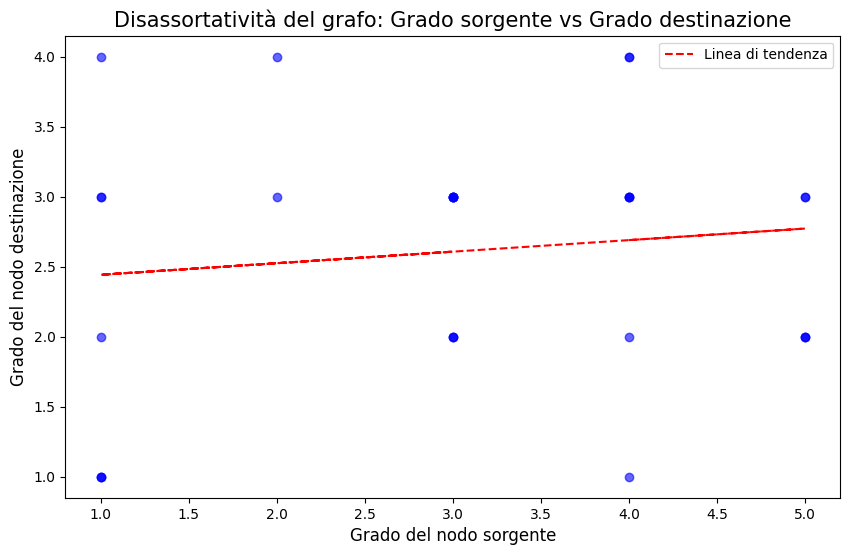

In [20]:
import numpy as np

# Estrai il grado dei nodi (in-degree e out-degree)
out_degree = dict(G.out_degree())
in_degree = dict(G.in_degree())

# Crea due liste: gradi sorgente e gradi destinazione per ogni arco
source_degrees = []
target_degrees = []

for source, target in G.edges():
    source_degrees.append(out_degree[source])
    target_degrees.append(in_degree[target])

# Visualizza il grafico della disassortatività
plt.figure(figsize=(10, 6))

# Crea un grafico di dispersione tra gradi sorgente e destinazione
plt.scatter(source_degrees, target_degrees, alpha=0.6, color='blue')

# Imposta i titoli e le etichette degli assi
plt.title("Disassortatività del grafo: Grado sorgente vs Grado destinazione", fontsize=15)
plt.xlabel("Grado del nodo sorgente", fontsize=12)
plt.ylabel("Grado del nodo destinazione", fontsize=12)

# Aggiungi una linea di tendenza
z = np.polyfit(source_degrees, target_degrees, 1)
p = np.poly1d(z)
plt.plot(source_degrees, p(source_degrees), "r--", label="Linea di tendenza")

# Mostra la legenda
plt.legend()

# Visualizza il grafico
plt.show()


# HUB trovati

In [21]:
import pandas as pd
import networkx as nx
import numpy as np

# Calcola il grado di ogni nodo
degree_sequence = G.degree()  # Restituisce una lista di tuple (nodo, grado)

# Trasforma in DataFrame per comodità
degree_df = pd.DataFrame(degree_sequence, columns=['PORT_CODE', 'Grado'])

# Definisci una soglia per gli hub, ad esempio il 90° percentile
threshold = np.percentile(degree_df['Grado'], 90)

# Filtra i nodi che hanno un grado maggiore o uguale alla soglia
hub_nodes_df = degree_df[degree_df['Grado'] >= threshold]

# Unisci il DataFrame degli hub con il DataFrame 'ports' per ottenere i nomi dei porti
hub_nodes_df = pd.merge(hub_nodes_df, ports[['PORT_CODE', 'PORT_NAME']], on='PORT_CODE', how='left')

# Visualizza il DataFrame con PORT_CODE, PORT_NAME e Grado degli hub
print(hub_nodes_df[['PORT_CODE', 'PORT_NAME', 'Grado']])

# Se vuoi visualizzare il numero di hub trovati
print(f"Numero di hub trovati: {len(hub_nodes_df)}")


   PORT_CODE     PORT_NAME  Grado
0          0      Belfast       7
1          1       Dublino      7
2          2  Southampton       8
3          4    Liverpool       7
Numero di hub trovati: 4


# clique massimali
la clique massimale è questa ['Dublino', 'Belfast ', 'Holyhead', 'Liverpool ']

Cliques massimali trovate:
['Dublino', 'Belfast ', 'Holyhead', 'Liverpool ']


/tmp/ipykernel_17/705934833.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(maximal_cliques))


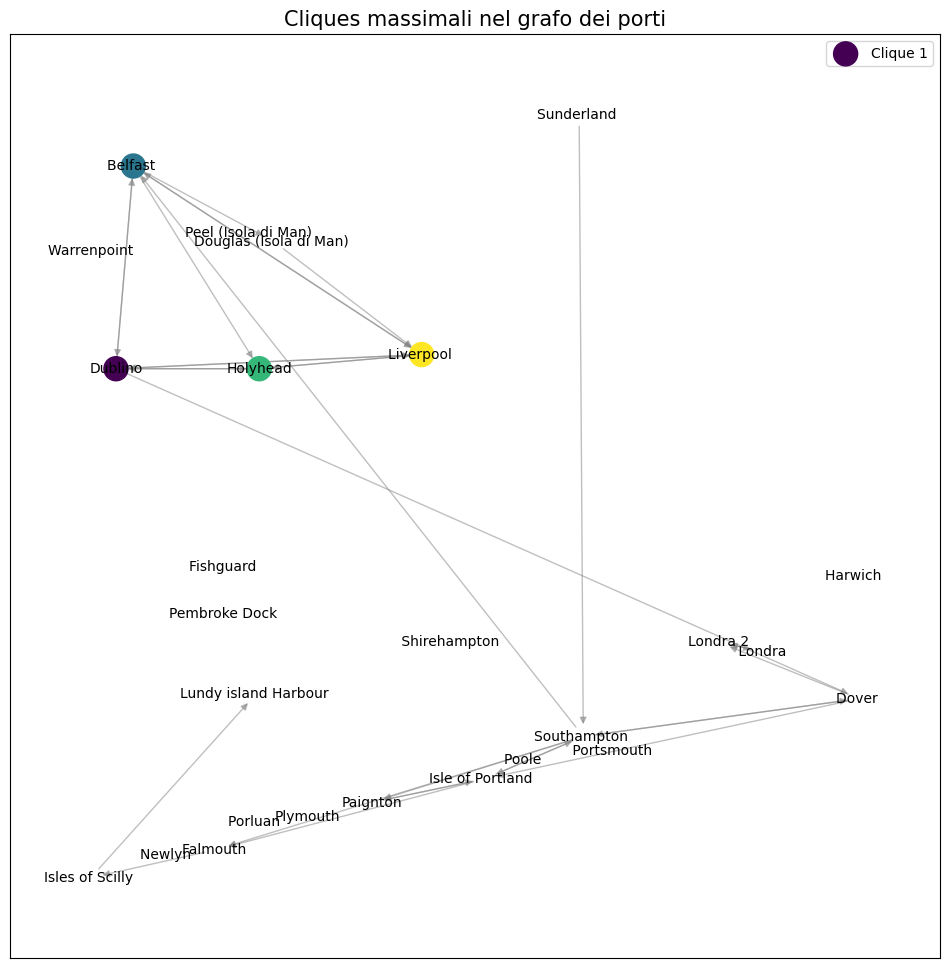

In [22]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Trova tutte le cliques massimali nel grafo
cliques = list(nx.find_cliques(G.to_undirected()))

# Filtra le cliques in base alla dimensione minima desiderata (ad esempio, almeno 3 nodi)
min_clique_size = 4
maximal_cliques = [clique for clique in cliques if len(clique) >= min_clique_size]

# Stampa le cliques massimali trovate con i nomi dei porti
print("Cliques massimali trovate:")
for clique in maximal_cliques:
    port_names = [ports.loc[ports['PORT_CODE'] == port, 'PORT_NAME'].values[0] for port in clique]
    print(port_names)

# Opzionale: visualizza le cliques sul grafo
plt.figure(figsize=(12, 12))
pos = nx.get_node_attributes(G, 'pos')

# Disegna il grafo
nx.draw_networkx_edges(G, pos, edge_color='grey', alpha=0.5)

# Colora le cliques in modo diverso
colors = plt.cm.get_cmap('tab10', len(maximal_cliques))
for idx, clique in enumerate(maximal_cliques):
    nx.draw_networkx_nodes(G, pos, nodelist=clique, node_color=colors(idx), label=f'Clique {idx + 1}', node_size=300)

# Disegna le etichette dei nodi usando PORT_NAME
node_labels = {row['PORT_CODE']: row['PORT_NAME'] for index, row in ports.iterrows()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')

# Aggiungi una legenda
plt.legend()
plt.title("Cliques massimali nel grafo dei porti", fontsize=15)
plt.show()


# robustezza della rete
La rete mostra una resistenza decrescente ma graduale. Questo significa che la rete ha un buon grado di robustezza, in quanto non collassa immediatamente con la rimozione di pochi nodi, ma richiede la rimozione progressiva di molti nodi prima di perdere completamente la sua componente fortemente connessa più grande.

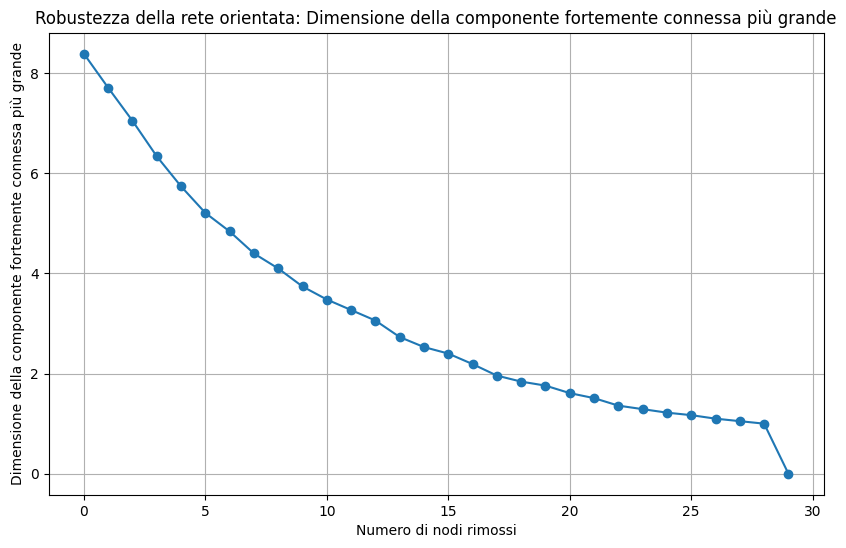

In [23]:
import pandas as pd
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt

# Funzione per calcolare la dimensione della componente fortemente connessa più grande
def largest_strongly_connected_component_size(G):
    scc = list(nx.strongly_connected_components(G))  # Ottieni le componenti fortemente connesse
    if not scc:  # Se non ci sono componenti
        return 0
    return max(len(c) for c in scc)

# Numero di simulazioni
num_simulations = 100

# Dimensione originale del grafo
original_size = G.number_of_nodes()

# Array per memorizzare i risultati delle simulazioni
results = np.zeros((num_simulations, original_size))

# Esegui le simulazioni
for simulation in range(num_simulations):
    G_copy = G.copy()  # Copia del grafo originale
    nodes = list(G_copy.nodes())
    random.shuffle(nodes)  # Mescola i nodi
    
    for i in range(original_size):
        G_copy.remove_node(nodes[i])  # Rimuovi il nodo
        # Calcola la dimensione della componente fortemente connessa più grande
        results[simulation, i] = largest_strongly_connected_component_size(G_copy)

# Calcola la media delle dimensioni della componente fortemente connessa per ciascun numero di nodi rimossi
mean_results = np.mean(results, axis=0)

# Visualizzazione dei risultati
plt.figure(figsize=(10, 6))
plt.plot(range(original_size), mean_results, marker='o')
plt.title('Robustezza della rete orientata: Dimensione della componente fortemente connessa più grande')
plt.xlabel('Numero di nodi rimossi')
plt.ylabel('Dimensione della componente fortemente connessa più grande')
plt.grid(True)
plt.show()
